# Model Retraining

- Setting up retraining pipelines, frequencies of retraining
- Training data preparation and storage
- Concept of Data Drift and how to track it
- Automated model retraining and model deployment

# Strategies to scale computationally
For some applications the amount of examples, features (or both) and/or the speed at which they need to be processed are challenging for traditional approaches. In these cases scikit-learn has a number of options you can consider to make your system scale.

### Scaling with instances using out-of-core learning
Out-of-core (or “external memory”) learning is a technique used to learn from data that cannot fit in a computer’s main memory (RAM).
Here is sketch of a system designed to achieve this goal:
- a way to stream instances
- a way to extract features from instances
- an incremental algorithm

We will look at 3 ways of doing this

1. Streaming instances
2. Extracting features
3. Incremental learning

### Incremental learning

Although all algorithms cannot learn incrementally (i.e. without seeing all the instances at once), all estimators implementing the partial_fit API are candidates. 

Actually, the ability to learn incrementally from a mini-batch of instances (sometimes called “online learning”) is key to out-of-core learning as it guarantees that at any given time there will be only a small amount of instances in the main memory. 

Choosing a good size for the mini-batch that balances relevancy and memory footprint could involve some tuning.

Here is a list of incremental estimators for different tasks:

### Classification
- ```sklearn.naive_bayes.MultinomialNB```
- ```sklearn.naive_bayes.BernoulliNB```
- ```sklearn.linear_model.Perceptron```
- ```sklearn.linear_model.SGDClassifier```
- ```sklearn.linear_model.PassiveAggressiveClassifier```

### Regression
- ```sklearn.linear_model.SGDRegressor```
- ```sklearn.linear_model.PassiveAggressiveRegressor```

### Clustering
- ```sklearn.cluster.MiniBatchKMeans```

### Decomposition / feature Extraction
- ```sklearn.decomposition.MiniBatchDictionaryLearning```
- ```sklearn.cluster.MiniBatchKMeans```

For classification, a somewhat important thing to note is that although a stateless feature extraction routine may be able to cope with new/unseen attributes, the incremental learner itself may be unable to cope with new/unseen targets classes. 

In this case you have to pass all the possible classes to the first ```partial_fit``` call using the ```classes= parameter```.

Another aspect to consider when choosing a proper algorithm is that all of them don’t put the same importance on each example over time. 

Namely, the Perceptron is still sensitive to badly labeled examples even after many examples whereas the ```SGD*``` and ```PassiveAggressive*``` families are more robust to this kind of artifacts. 

Conversely, the later also tend to give less importance to remarkably different, yet properly labeled examples when they come late in the stream as their learning rate decreases over time.

### Examples

Finally, we have a full-fledged example of Out-of-core classification of text documents. It is aimed at providing a starting point for people wanting to build out-of-core learning systems and demonstrates most of the notions discussed above.

Furthermore, it also shows the evolution of the performance of different algorithms with the number of processed examples.


![](https://scikit-learn.org/0.15/_images/plot_out_of_core_classification_001.png)

Now looking at the computation time of the different parts, we see that the vectorization is much more expensive than learning itself. From the different algorithms, MultinomialNB is the most expensive, but its overhead can be mitigated by increasing the size of the mini-batches (exercise: change minibatch_size to 100 and 10000 in the program and compare).

![](https://scikit-learn.org/0.15/_images/plot_out_of_core_classification_003.png)

### Classification
- ```sklearn.naive_bayes.MultinomialNB```
- ```sklearn.naive_bayes.BernoulliNB```
- ```sklearn.linear_model.Perceptron```
- ```sklearn.linear_model.SGDClassifier```
- ```sklearn.linear_model.PassiveAggressiveClassifier```

### MultinomialNB

In [1]:
### Let's load some data
import pandas as pd

In [2]:
df = pd.read_csv('datasets/Loan_default.csv')

In [3]:
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


### Let's do some data cleaning

In [4]:
df = df.drop('LoanID',axis=1)

In [5]:
df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [6]:
df.isna().sum()

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

<Axes: >

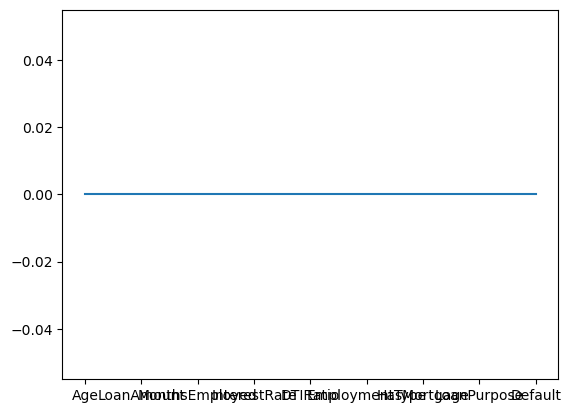

In [7]:
df.isna().sum().plot()

#### Wow, no missing values, my lucky day

![](https://i.pinimg.com/originals/c2/b0/9a/c2b09a209f8132aeb6de8d59bad31229.gif)

### Data Preprocessing
Let's just get started on converting the categorical columns to numbers

In [8]:
pd.get_dummies(df)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,True,False,True,False,False,False,False,True,True,False


I know........

I know........

Not the best, but will do for now.

In [9]:
df_encoded = pd.get_dummies(df) 

In [10]:
df_encoded

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,True,False,True,False,False,False,False,True,True,False


### Splitting X and Y

In [11]:
X = df_encoded.drop('Default',axis=1)
y = df_encoded['Default']

In [12]:
X

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_Bachelor's,...,HasMortgage_Yes,HasDependents_No,HasDependents_Yes,LoanPurpose_Auto,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_No,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,True,...,True,False,True,False,False,False,False,True,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,False,...,False,True,False,False,False,False,False,True,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,False,...,True,False,True,True,False,False,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,False,...,False,True,False,False,True,False,False,False,True,False
4,60,20437,9139,633,8,4,6.51,48,0.73,True,...,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,True,...,False,True,False,False,False,False,False,True,True,False
255343,32,51953,189899,511,14,2,11.55,24,0.21,False,...,False,True,False,False,False,False,True,False,True,False
255344,56,84820,208294,597,70,3,5.29,60,0.50,False,...,True,False,True,True,False,False,False,False,False,True
255345,42,85109,60575,809,40,1,20.90,48,0.44,False,...,True,False,True,False,False,False,False,True,True,False


In [13]:
y

0         0
1         0
2         1
3         0
4         0
         ..
255342    0
255343    1
255344    0
255345    0
255346    0
Name: Default, Length: 255347, dtype: int64

### Time for train test split 

### Now that my dataset is ready 
I am going to split my data not into train and test, but rather train/validate/test to prove my point

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, train_size=0.67, random_state=42)

### So now
```33%``` of my data is in ```X_test``` and ```y_test```, I will reserve this for later.

The remaining ```66%``` of my data is in ```X_train``` and ```y_train```

### Splitting it again



In [16]:
# Split the data into training and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.5, train_size=0.5, random_state=42)

```X_train_2``` and ```y_train_2``` is what i will use for training. 

```X_test``` and ```y_test``` is what i will use for testing.

### Let's Begin !!!!

```MultinomialNB```

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
# Initialise the model
clf = MultinomialNB()

# Train the model 
clf.fit(X_train_2, y_train_2)

MultinomialNB()

### Training Done
### Predict on the test set

In [20]:
# Getting my predictions
clf.predict(X_test_2)

array([1, 0, 0, ..., 1, 0, 1])

In [22]:
# Saving my predictions
pred = clf.predict(X_test_2)

### Get some metrics

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, pred)

0.5780035304707684

### Saving the model

In [24]:
from joblib import load,dump

In [26]:
dump(clf,'models/MultinomialNB.pkl')

['models/MultinomialNB.pkl']

### Now, this is where we would typically stop. 

But not this time !!!!!!!!!!

In [27]:
loaded_model = load('models/MultinomialNB.pkl')

In [29]:
loaded_model

MultinomialNB()

In [31]:
# ############### Only for demonstration purposes ###############


# # What happens if you do fit
# loaded_model.fit(new_data)

# # What happens if you do this 
# loaded_model.partial_fit(new_data)

# # Additionally what happens when you do this 
# loaded_model.fit(new_data, warm_start=True)

# ############################################################

### Time for training on top

In [49]:
loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [56]:
# For testing
for i in range(100):
    loaded_model_trained = loaded_model.partial_fit(X_train,y_train)

In [57]:
loaded_model_trained

MultinomialNB()

In [58]:
# Getting my predictions
loaded_model_trained.predict(X_test_2)

array([1, 0, 0, ..., 1, 0, 1])

In [59]:
# Storing my predictions
loaded_model_pred = loaded_model_trained.predict(X_test_2)

In [60]:
# Here are my predictions
loaded_model_pred

array([1, 0, 0, ..., 1, 0, 1])

In [61]:
# Getting my accuracy 

from sklearn.metrics import accuracy_score

accuracy_score(y_test_2, loaded_model_pred)

0.5785880454986497

In [ ]:
# For initial
0.5780035304707684

# For 1 run 
0.57833

# For 5 runs
0.5785529745969769

# For 25 runs
0.5785763551980921

# For 100 more
0.5785880454986497

-----

```BernoulliNB```

In [209]:
from sklearn.naive_bayes import BernoulliNB

In [210]:
clf = BernoulliNB()
clf.fit(X_train_2, y_train_2)

BernoulliNB()